<a href="https://colab.research.google.com/github/Simon-delalande/Using-persistent-homology-and-transformers-for-classification-/blob/main/attention_TDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.7 MB 1.6 MB/s 


In [32]:
from os import chdir
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import pandas as pd
import pickle as pickle
import math
import gudhi as gd
from sklearn import preprocessing

import tensorflow as tf 
import keras
from keras.layers import Dense, MultiHeadAttention, LayerNormalization, Dropout


# Data preparation


The walk of 3 persons A, B and C, has been recorded using the accelerometer sensor of a smartphone in their pocket, giving rise to 3 multivariate time series in : each time series represents the 3 coordinates of the acceleration of the corresponding walker in a coordinate system attached to the sensor.

Notice that the smartphone was carried in a possibly different position for each person and thus these time series cannot be compared coordinates by coordinates.



We will try here to predict from which person a point cloud comes from by using a classification algorithm on the persistent diagram of the point cloud. 

Such diagrams can be seen as a sequence of vectors in R^2, but with no particular order. We will thus use an attention model, inspired by BERT, which can procede sequences of any lengths of vectors and map the interactions between them. 

In [3]:
f = open("/content/drive/MyDrive/data_acc","rb")
data = pickle.load(f)    
f.close()

In [4]:
data_A = data[0]
data_B = data[1] 
data_C = data[2]
label  = data[3]

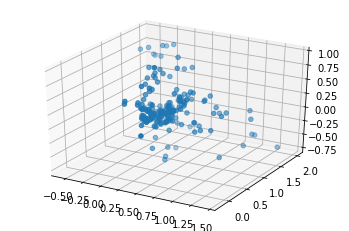

In [5]:
data_A_sample = data_A[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(data_A_sample[:, 0], data_A_sample[:, 1], data_A_sample[:, 2]);

The labels are one hot encoded to perform the classification 

In [12]:
def convert_label(label):
  A= np.zeros((label.shape[0], 3))
  for i in range(label.shape[0]):
    if label[i] == 'A': A[i,:]= np.array([1.0, 0.0, 0.0])
    elif label[i] == 'B': A[i,:] = np.array([0.0, 1.0, 0.0])
    else: A[i,:] = np.array([0.0, 0.0, 1.0])

  return(A)

labels= convert_label(label)

The homological features with an inf death time are removed. In this case it correspond only to the largest connex component, which is present in all diagram so no information is lost. 

In [ ]:
def remove_inf(array):
  L= []
  l=0
  for i in array:
    if i[1]== math.inf:
      L.append(l)
    l+=1

  array= np.delete(array, L, 0)
  return array

Each point cloud is transformed into a persistent diagram

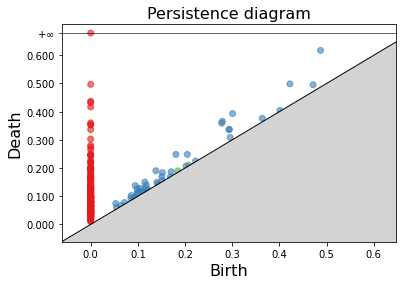

In [ ]:
skeleton= gd.RipsComplex(points= data_A[0], max_edge_length= 3)
rips_simplex_tree= skeleton.create_simplex_tree(max_dimension= 3)
bar_code= rips_simplex_tree.persistence()

gd.plot_persistence_diagram(bar_code)


In [ ]:
max_edge_length= 1.5
max_dim= 2

def preprocess(data_sample):

  skeleton= gd.RipsComplex(points= data_sample, max_edge_length= max_edge_length)
  Rips_simplex_tree= skeleton.create_simplex_tree(max_dimension= max_dim)
  Rips_simplex_tree.compute_persistence(2)
  return remove_inf(np.concatenate((Rips_simplex_tree.persistence_intervals_in_dimension(0), Rips_simplex_tree.persistence_intervals_in_dimension(1))))

In [10]:
data_all= np.reshape(data[0:3], (300, 200, 3))

In order for our model to process batches of data, all diagrams must have the same length. We thus pad the diagrams (seen as a sequence of R2 vectors). 

In [ ]:
max_size= 0
for i in data_all:
  size= preprocess(i).shape[0]
  if size> max_size:
    max_size= size

print(max_size)

275


Here  max_size= 275

In [ ]:
def padd(persistence, max_size):
  assert persistence.shape[0] <= max_size
  pad= np.zeros((max_size-persistence.shape[0], 2))
  return np.concatenate((persistence, pad))

In [ ]:
final_data= np.zeros((300,275,2))
l=0
for i in data_all:
  final_data[l,:,:]= padd(preprocess(i), max_size)
  l+=1

In [ ]:
with open('parrot.pkl', 'wb') as f:
  pickle.dump(final_data, f)

NameError: ignored

We add a cls token to perform the classification on 

In [28]:
f= open("/content/drive/MyDrive/parrot.pkl", "rb")
processed_data= pickle.load(f)
f.close()

In [29]:
processed_data.shape

(300, 275, 2)

A classification token is added at the end of the diagrams, on which the classification will be done 

In [30]:
def add_cls_token(data):
  token= np.ones(shape= (300, 1,2))
  token *= 1.5
  data_cls= np.concatenate((data, token), axis= 1)
  return data_cls


processed_data= add_cls_token(processed_data)

In [31]:
processed_data.shape

(300, 276, 2)

The data is centered and normalized, which has tremendous effect on the model's performances. 

In [ ]:
X= np.reshape(processed_data, (300,-1))
X= preprocessing.StandardScaler().fit_transform(X)
X= np.reshape(X, (300,276,2))

It is then shuffled and split into a train and a test set

In [ ]:
idx = np.random.permutation(300)
x,y = X[idx], labels[idx]

In [ ]:
test_size= 40
X_train, y_train= x[test_size:,:,:], y[test_size:, :]
X_test, y_test= x[0:test_size,:,:], y[0:test_size,:]

# Model creation

Model creation:
The model is a succession of transformers encoders units. 
Here, the use of layer normalization impede the model to learn for an unknown reason. It has thus been removed. 

In [33]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, num_heads,  embedding_dim, fully_connected_dim =2,
                 layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn1 = Dense(fully_connected_dim, activation='relu')
        self.ffn2= Dense(embedding_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.inp= keras.Input(shape=(276,2))
        #self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x):

        attn_output = self.mha(x, x)

        #out1 = self.layernorm1(attn_output+ x)  
        out1= attn_output+x
        
        ffn_output = self.ffn1(out1) 
        ffn_output= self.ffn2(ffn_output)
        

        #encoder_layer_out = self.layernorm2(ffn_output+out1) 
        encoder_layer_out= ffn_output+ out1

        return encoder_layer_out
    

A classification layer with two dense layers is added on top of the mutiple encoders

In [42]:
class Encoder(tf.keras.Model):

    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, clf_dim,
                layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        #self.dropout = Dropout(dropout_rate)
        self.clf1= Dense(clf_dim, activation= 'relu')
        self.clf2= Dense(3, 'softmax')
        
    def call(self, x):

        seq_len = tf.shape(x)[1]
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        z= x[:,seq_len-1,:]
        z= self.clf1(z)
        z= self.clf2(z)


        return z  

In [43]:
model= Encoder(num_layers= 16, embedding_dim=2, num_heads=1, fully_connected_dim=256, clf_dim=256)

In [ ]:
model.compile(optimizer= 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

In [ ]:
history= model.fit(x= X_train, y= y_train, batch_size= 16, validation_split= 0.1, epochs= 50)

Epoch 1/50
15/15 [==============================] - 9s 146ms/step - loss: 1.7652 - accuracy: 0.5684 - val_loss: 0.9207 - val_accuracy: 0.4615
Epoch 2/50
15/15 [==============================] - 1s 47ms/step - loss: 0.9576 - accuracy: 0.6368 - val_loss: 0.8296 - val_accuracy: 0.6154
Epoch 3/50
15/15 [==============================] - 1s 47ms/step - loss: 0.8012 - accuracy: 0.6667 - val_loss: 0.7011 - val_accuracy: 0.6923
Epoch 4/50
15/15 [==============================] - 1s 47ms/step - loss: 0.6930 - accuracy: 0.6880 - val_loss: 0.6262 - val_accuracy: 0.6923
Epoch 5/50
15/15 [==============================] - 1s 48ms/step - loss: 0.6046 - accuracy: 0.7137 - val_loss: 0.5665 - val_accuracy: 0.7308
Epoch 6/50
15/15 [==============================] - 1s 47ms/step - loss: 0.5636 - accuracy: 0.8077 - val_loss: 0.5446 - val_accuracy: 0.7308
Epoch 7/50
15/15 [==============================] - 1s 47ms/step - loss: 0.4676 - accuracy: 0.8034 - val_loss: 0.4446 - val_accuracy: 0.8846
Epoch 8/50
1

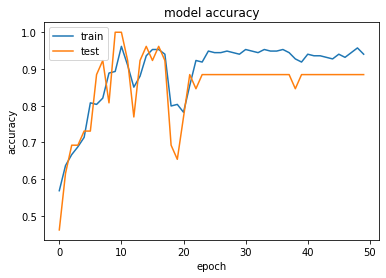

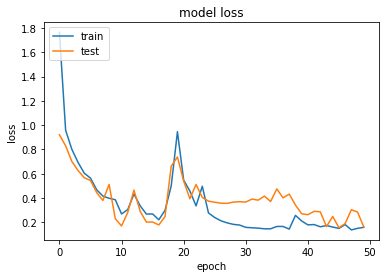

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Testing the model 

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=32)
print(results)

2/2 [==============================] - 0s 25ms/step - loss: 0.3021 - accuracy: 0.9000
[0.30213460326194763, 0.8999999761581421]


We get an accuracy of 0.9 on the test set. It is pretty good considering that we are only using topological informations about the data in order to classify it. 

# Classical model

We use the same model architecture on the raw data extracted from the sensors to compare the performances

In [13]:
x,y = data_all[idx], labels[idx]

In [18]:
def add_cls_token(data):
  token= np.zeros(shape= (300, 1,3))
  data_cls= np.concatenate((data, token), axis= 1)
  return data_cls


x= add_cls_token(x)

In [19]:
x.shape

(300, 201, 3)

In [23]:
x= np.reshape(x, (300,-1))
x= preprocessing.StandardScaler().fit_transform(x)
x= np.reshape(x, (300,201,3))

In [24]:
test_size= 40
x_test, y_test= x[:test_size], y[:test_size]
x_train, y_train= x[test_size:], y[test_size:]


In [45]:
model2= Encoder(num_layers= 16, embedding_dim=3, num_heads=1, fully_connected_dim=256, clf_dim=256)

In [46]:
model2.compile(optimizer= 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

In [47]:
history= model2.fit(x= x_train, y= y_train, batch_size= 16, validation_split= 0.1, epochs= 50)

Epoch 1/50
15/15 [==============================] - 18s 506ms/step - loss: 2.3035 - accuracy: 0.2650 - val_loss: 0.7233 - val_accuracy: 0.5000
Epoch 2/50
15/15 [==============================] - 5s 358ms/step - loss: 0.8551 - accuracy: 0.5427 - val_loss: 0.6392 - val_accuracy: 0.6923
Epoch 3/50
15/15 [==============================] - 5s 342ms/step - loss: 0.7387 - accuracy: 0.6838 - val_loss: 0.5414 - val_accuracy: 0.9231
Epoch 4/50
15/15 [==============================] - 5s 356ms/step - loss: 0.6055 - accuracy: 0.8504 - val_loss: 0.4339 - val_accuracy: 0.9231
Epoch 5/50
15/15 [==============================] - 5s 356ms/step - loss: 0.5440 - accuracy: 0.8248 - val_loss: 0.4804 - val_accuracy: 0.8462
Epoch 6/50
15/15 [==============================] - 5s 366ms/step - loss: 0.5572 - accuracy: 0.7863 - val_loss: 0.4104 - val_accuracy: 0.8077
Epoch 7/50
15/15 [==============================] - 9s 631ms/step - loss: 0.6426 - accuracy: 0.7863 - val_loss: 0.5496 - val_accuracy: 0.8077
Epoch

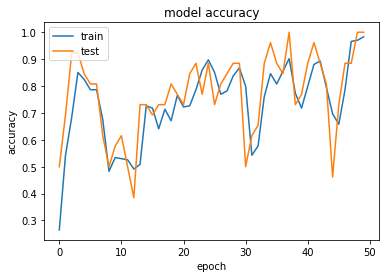

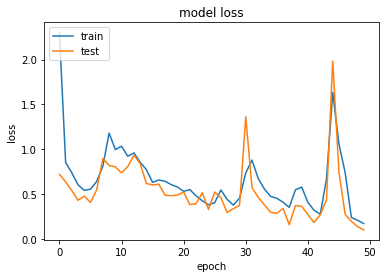

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
results = model2.evaluate(x_test, y_test, batch_size=32)
print(results)

2/2 [==============================] - 0s 95ms/step - loss: 0.4637 - accuracy: 0.8750
[0.4637420177459717, 0.875]
